In [1]:
!pip install Arabic-Stopwords
!pip install arabic_reshaper
!pip install python-bidi

     |████████████████████████████████| 353 kB 5.3 MB/s 
     |████████████████████████████████| 126 kB 53.0 MB/s 


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import string
import arabicstopwords.arabicstopwords as ar_words
import os
import codecs
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
import collections

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [59]:
#read files of first dataset (MSA)
cor_df=pd.read_csv('ArSenTD-LEV.tsv', sep='\t')
cor_df

,Tweet,Country,Topic,Sentiment,Sentiment_Expression,Sentiment_Target
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",lebanon,personal,negative,implicit,بريق العيون
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,jordan,sports,positive,explicit,افضل لاعب في العالم
2,لا نخلو من ضغوطات الحياة. فنحن نعيش على أرض أع...,palestine,personal,neutral,none,none
3,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,lebanon,personal,negative,explicit,مصطلحات_لبنانيه
4,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,palestine,personal,negative,explicit,س لم تعد كما ك
...,...,...,...,...,...,...
3995,صلاح من لاعب في المقاولون العرب يحلم ان يلعب ل...,lebanon,sports,very_positive,explicit,بطل قومي
3996,الملك سلمان بن عبد العزيز: تطبيق الأنظمة بحزم ...,lebanon,politics,positive,explicit,أساء استغلال السلطة والنفوذ
3997,@ZahraaIraq9 😂 كل ما ادخل حسابي الكه تغريداتج ...,jordan,personal,negative,explicit,تغريداتج عن حب العراق
3998,شو هالشعب نحنا اللي عايش بلا مي وكهربا والزبال...,lebanon,politics,very_negative,explicit,عايش بلا مي وكهربا


In [60]:
cor_df= cor_df.drop(columns=['Country', 'Sentiment_Expression','Sentiment_Target'])
cor_df

,Tweet,Topic,Sentiment
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",personal,negative
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,sports,positive
2,لا نخلو من ضغوطات الحياة. فنحن نعيش على أرض أع...,personal,neutral
3,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,personal,negative
4,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,personal,negative
...,...,...,...
3995,صلاح من لاعب في المقاولون العرب يحلم ان يلعب ل...,sports,very_positive
3996,الملك سلمان بن عبد العزيز: تطبيق الأنظمة بحزم ...,politics,positive
3997,@ZahraaIraq9 😂 كل ما ادخل حسابي الكه تغريداتج ...,personal,negative
3998,شو هالشعب نحنا اللي عايش بلا مي وكهربا والزبال...,politics,very_negative


In [61]:
#keep only binary classes (pos & neg)
cor_df=cor_df[cor_df['Sentiment']!='neutral'].reset_index(drop=True)

In [62]:
#unify format with other dataset
cor_df['Sentiment'].replace({'very_positive': '1', 'positive': '1', 'very_negative':'0', 'negative':'0'}, inplace=True)
cor_df= cor_df.reset_index(drop=True)
cor_df.rename(columns={'Tweet': 'text', 'Sentiment': 'polarity'}, inplace=True)
cor_df["polarity"] = pd.to_numeric(cor_df["polarity"])

In [63]:
cor_df.head()

,text,Topic,polarity
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",personal,0
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,sports,1
2,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,personal,0
3,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,personal,0
4,@Yousef_MUFC اكثر ما يزعجنا بعد مستوانا خارج ا...,sports,0


In [64]:
cor_df['Topic'].value_counts()

politics         1237
personal         1078
sports            384
religions         227
entertainment     132
news               17
weather             8
education           6
technology          6
science             5
health              4
advertisement       4
economy             3
volunteering        2
jobs                1
palestine           1
Name: Topic, dtype: int64

In [65]:
per_df= cor_df[cor_df['Topic']=='personal']
spo_df= cor_df[cor_df['Topic']=='sports']
pol_df= cor_df[cor_df['Topic']=='politics']
rel_df= cor_df[cor_df['Topic']=='religions']

datasetDict = {"All":cor_df, "personal": per_df, "sports": spo_df, "politics": pol_df, "religions": rel_df}

In [38]:
#dataset sizes
print('-DATASET-','-SIZE-')
total=0
for k, v in datasetDict.items():
    print(k, len(v))
    print(v.polarity.value_counts(normalize=True))
    total+= len(v)
print('TOTAL',total)

-DATASET- -SIZE-
All 3115
0    0.604494
1    0.395506
Name: polarity, dtype: float64
personal 1078
0    0.511132
1    0.488868
Name: polarity, dtype: float64
sports 384
0    0.541667
1    0.458333
Name: polarity, dtype: float64
politics 1237
0    0.808407
1    0.191593
Name: polarity, dtype: float64
religions 227
1    0.810573
0    0.189427
Name: polarity, dtype: float64
TOTAL 6041


In [66]:
lev_text_list = cor_df['text'].values # extract text column as list
lev_words_list = [text.split() for text in lev_text_list] # split each tweet into the corresponding words
lev_words = [word for text_words in lev_words_list for word in text_words] # merge words into one list
print('Total number of words: ', len(lev_words))
print('Total number of unique words: ', len(set(lev_words)))

Total number of words:  71242
Total number of unique words:  22221


In [67]:
#check for null values
for k, v in datasetDict.items():
    print(k,'\n',v.isnull().sum())

All 
 text        0
Topic       0
polarity    0
dtype: int64
personal 
 text        0
Topic       0
polarity    0
dtype: int64
sports 
 text        0
Topic       0
polarity    0
dtype: int64
politics 
 text        0
Topic       0
polarity    0
dtype: int64
religions 
 text        0
Topic       0
polarity    0
dtype: int64


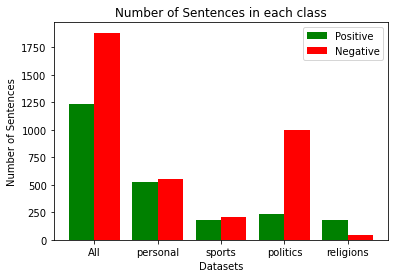

In [68]:
pos = []
neg = []
X = []
for k, v in datasetDict.items():
    pos.append(len(datasetDict[k][datasetDict[k]['polarity']==1]))
    neg.append(len(datasetDict[k][datasetDict[k]['polarity']==0]))
    X.append(k)

    X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, pos, 0.4, label = 'Positive', color='green')
plt.bar(X_axis + 0.2, neg, 0.4, label = 'Negative', color='red')
  
plt.xticks(X_axis, X)
plt.xlabel("Datasets")
plt.ylabel("Number of Sentences")
plt.title("Number of Sentences in each class")
plt.legend()
plt.show()

In [69]:
ar_sw=['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'إنها', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما','كان','كانت', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل', 'على', 'عليك', 'عليه', 'عما', 'عن', 'عند', 'غير', 'فإذا', 'فإن', 'فلا', 'فمن', 'في', 'فيم', 'فيما', 'فيه', 'فيها', 'قد', 'كأن', 'كأنما', 'كأي', 'كأين', 'كذا', 'كذلك', 'كل', 'كلا', 'كلاهما', 'كلتا', 'كلما', 'كليكما', 'كليهما', 'كم', 'كم', 'كما', 'كي', 'كيت', 'كيف', 'كيفما', 'لا', 'لاسيما', 'لدى', 'لست', 'لستم', 'لستما', 'لستن', 'لسن', 'لسنا', 'لعل', 'لك', 'لكم', 'لكما', 'لكن', 'لكنما', 'لكي', 'لكيلا', 'لم', 'لما', 'لن', 'لنا', 'له', 'لها', 'لهم', 'لهما', 'لهن', 'لو', 'لولا', 'لوما', 'لي', 'لئن', 'ليت', 'ليس', 'ليسا', 'ليست', 'ليستا', 'ليسوا', 'ما', 'ماذا', 'متى', 'مذ', 'مع', 'مما', 'ممن', 'من', 'منه', 'منها', 'منذ', 'مه', 'مهما', 'نحن', 'نحو', 'نعم', 'ها', 'هاتان', 'هاته', 'هاتي', 'هاتين', 'هاك', 'هاهنا', 'هذا', 'هذان', 'هذه', 'هذي', 'هذين', 'هكذا', 'هل', 'هلا', 'هم', 'هما', 'هن', 'هنا', 'هناك', 'هنالك', 'هو', 'هؤلاء', 'هي', 'هيا', 'هيت', 'هيهات', 'والذي', 'والذين', 'وإذ', 'وإذا', 'وإن', 'ولا', 'ولكن', 'ولو', 'وما', 'ومن', 'وهو', 'يا']

def normalizeArabic(t):
    t = re.sub("[إأٱآا]", "ا", t)
    t = re.sub("ى", "ي", t)
    t = re.sub("ة", 'ه', t)
    t = re.sub("ؤ", "ء", t)
    t = re.sub("ئ", "ء", t)
    return (t)

ar_stop= []
for w in ar_sw:
  ar_stop.append(normalizeArabic(w))

In [70]:
#COLLECT Ar stopwords from 2 sources
ar_stopwords = stopwords.words('arabic') + list(ar_words.stopwords_list()) + ar_stop
print('nlkt arabic stopwords =',len(stopwords.words('arabic')))
print('Arabic-Stopwords =', len(ar_words.stopwords_list()))
print('My list =', len(ar_stop))
print('sum =',len(ar_stopwords), 'unique=', len(set(ar_stopwords)) )

nlkt arabic stopwords = 754
Arabic-Stopwords = 13629
My list = 251
sum = 14634 unique= 13997


In [79]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [81]:
# define 'clean_tweet' function to clean the text and remove unwanted text parts
def clean_text(text):
    # define regular expression patterns
    p_english = "[a-zA-Z0-9]+"
    p_url = "https?://[A-Za-z0-9./]+"
    p_mention = "\@[\_0-9a-zA-Z]+\:?"    
    p_retweet = "RT \@[\_\-0-9a-zA-Z]+\:?"
    p_punctuations = "[" + string.punctuation + "]"
    
    # remove unwanted parts
    text = re.sub(p_english, ' ', text)
    text = re.sub(p_retweet, ' ', text)
    text = re.sub(p_mention, ' ', text)
    text = re.sub(p_url, ' ', text)
    text = re.sub(p_punctuations, ' ', text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    # remove الهمزة
    text = re.sub("[أإآ]", 'ا', text)
    text = re.sub("ة", 'ه', text)
    text = re.sub("ى", 'ي', text)
    
    # removing tashkeel
    tashkel = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(tashkel, '', text)
    
    # remove repeated letters more than two letters
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = text.strip()

    text= remove_emoji(text)
    
    # remove stopwords
    words = [word for word in text.split() if word not in ar_stopwords]
    words = [word for word in words if len(word)>=2]
    
    # merge and return final text
    return ' '.join(words)

In [82]:
# apply clean_tweet function on all tweets' text in the dataframe
for k, v in datasetDict.items():
    v['clean_text'] = v['text'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
#combine all domains in one frame to check stat about data
lev_clean_text_list = cor_df['clean_text'].values # extract text column as list
lev_clean_words_list = [text.split() for text in lev_clean_text_list] # split each tweet into the corresponding words
lev_clean_words = [word for text_words in lev_clean_words_list for word in text_words] # merge words into one list
print('---Before cleaning---')
print('Total number of words: ', len(lev_words))
print('Total number of unique words: ', len(set(lev_words)))
print('---After cleaning---')
print('Total number of words: ', len(lev_clean_words))
print('Total number of unique words: ', len(set(lev_clean_words)))
print('---Number of deleted words---')
print('Total number of deleted word:',len(lev_words)-len(lev_clean_words))
print('Total number of unique deleted word:',len(set(lev_words))-len(set(lev_clean_words)))

---Before cleaning---
Total number of words:  71242
Total number of unique words:  22221
---After cleaning---
Total number of words:  49150
Total number of unique words:  17054
---Number of deleted words---
Total number of deleted word: 22092
Total number of unique deleted word: 5167


Number of documents with words less than  5  in  All  dataset =  4


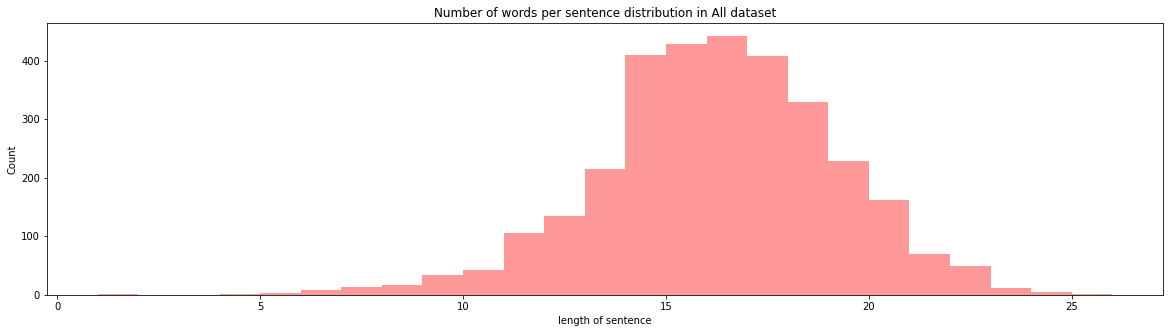

Number of documents with words less than  5  in  personal  dataset =  4


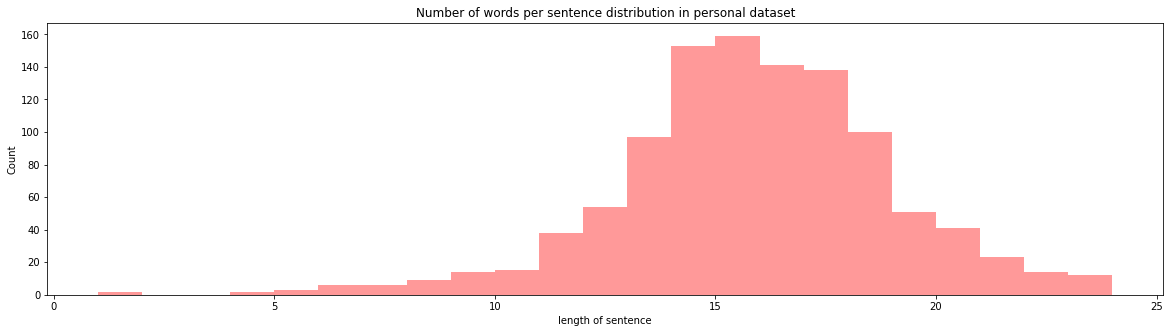

Number of documents with words less than  5  in  sports  dataset =  0


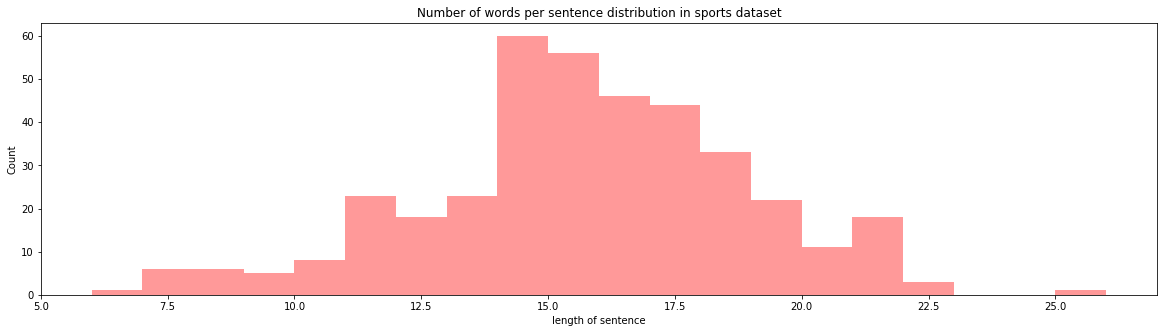

Number of documents with words less than  5  in  politics  dataset =  0


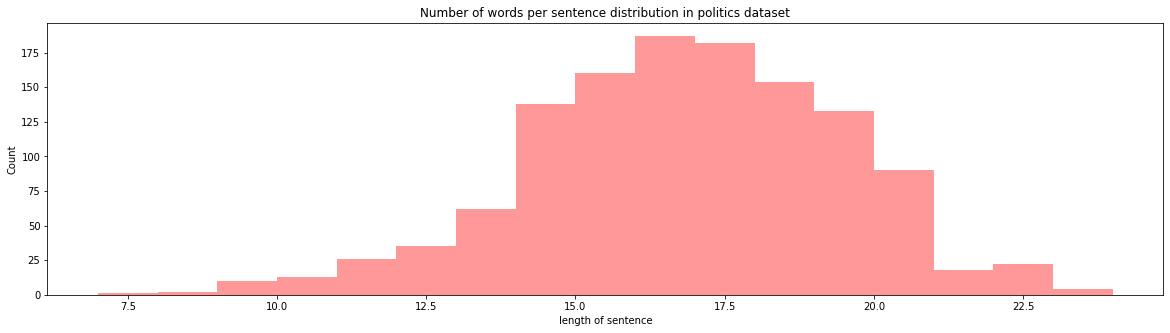

Number of documents with words less than  5  in  religions  dataset =  0


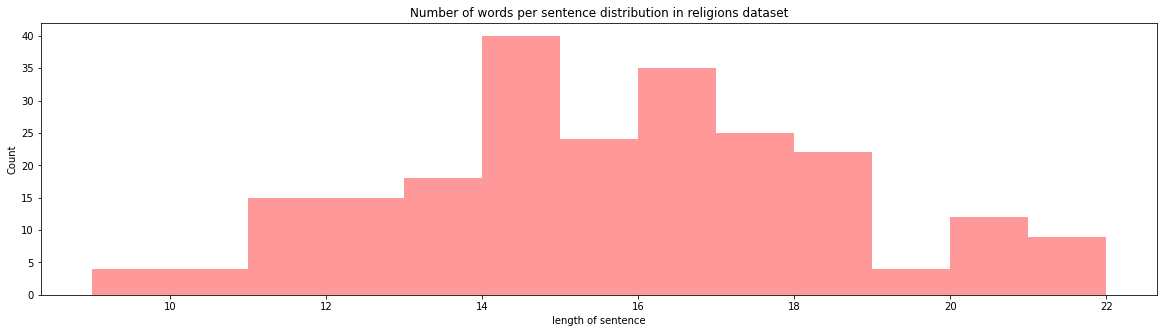

Number of documents with words less than  5  in all dataset =  8


In [84]:
#words distributions
min_words= 5
total_short=0
for k, v in datasetDict.items():
    sentences_len = [len(i.split()) for i in v['clean_text'] if i!=0]
    print('Number of documents with words less than ',min_words, ' in ',k, ' dataset = ',sum(1 for i in sentences_len if i < min_words))
    total_short+=sum(1 for i in sentences_len if i < min_words)
    plt.figure(figsize=(20,5))
    plt.hist( sentences_len, bins=range(min( sentences_len), max( sentences_len) + 1, 1), 
              alpha=0.4, color="red")
    plt.xlabel("length of sentence")
    plt.ylabel("Count")
    plt.title("Number of words per sentence distribution in "+ k + ' dataset')
    plt.show()
print('Number of documents with words less than ',min_words, ' in all dataset = ',total_short)

In [ ]:
#How to keep only doc with 5 words or more (change df to the df name)
#df[df['clean_text'].apply(len)>=min_words]

In [85]:
from bidi.algorithm import get_display
import arabic_reshaper
def reshape_text(text):
    rtext = arabic_reshaper.reshape(text)
    return get_display(rtext)

Total number of words:  49150
Total number of unique words:  17054


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


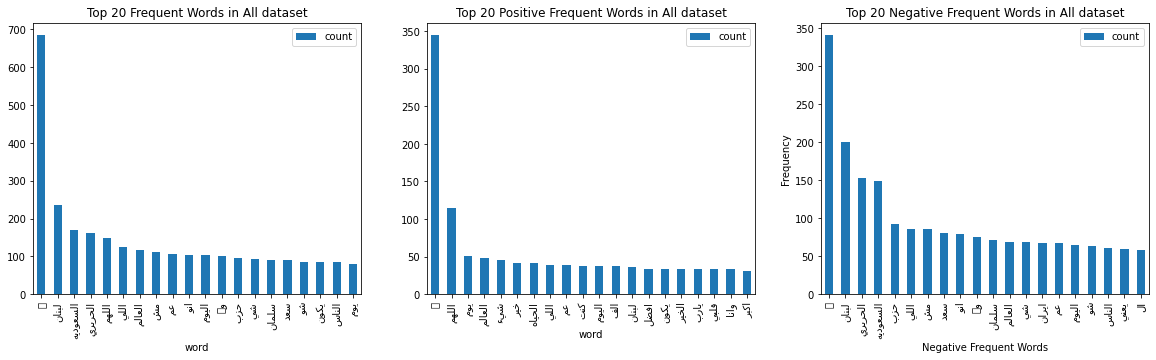

Total number of words:  16566
Total number of unique words:  8090


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


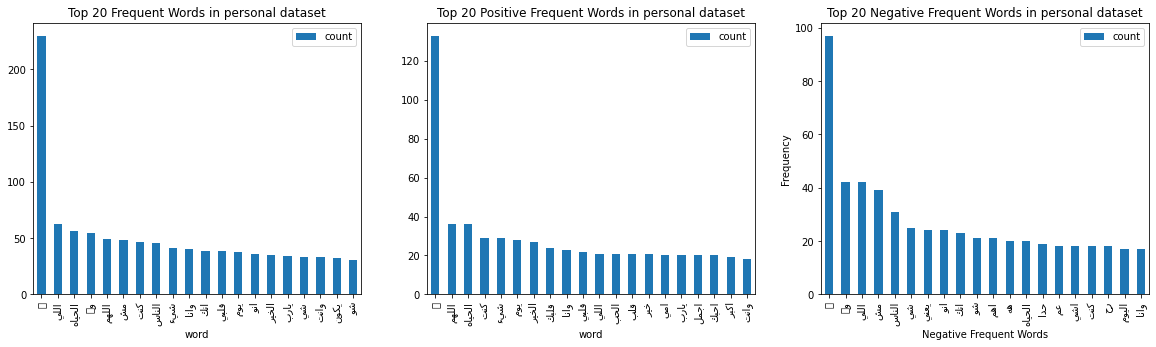

Total number of words:  5855
Total number of unique words:  2607


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


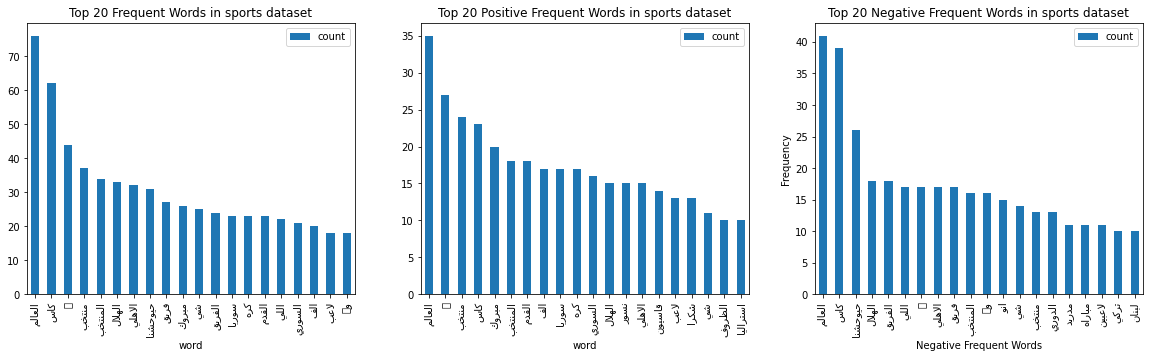

Total number of words:  20227
Total number of unique words:  7420


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


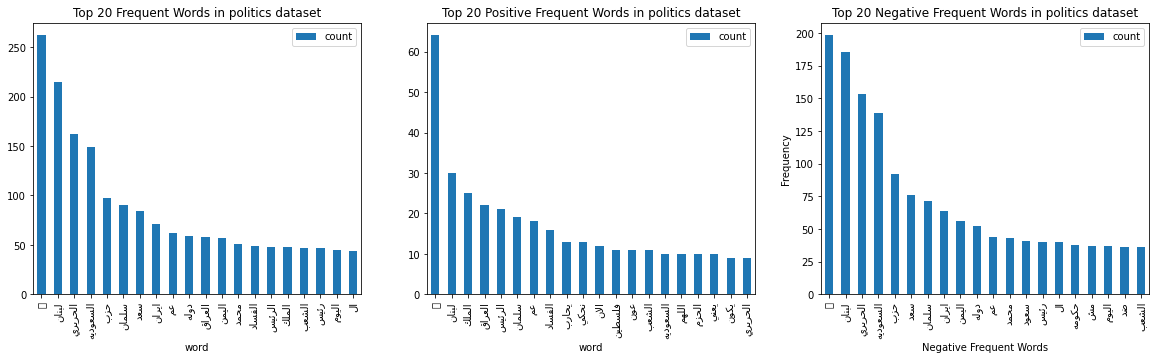

Total number of words:  3466
Total number of unique words:  1919


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


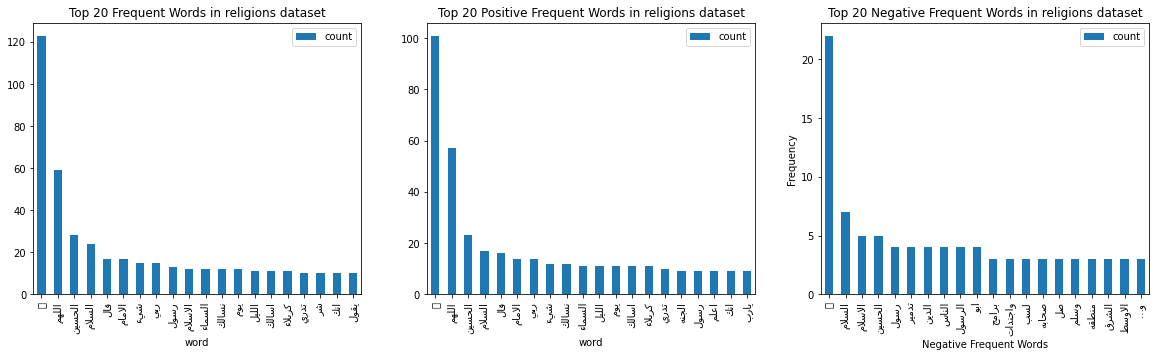

In [86]:
import collections

for k, v in datasetDict.items():
    all_text_list = v['clean_text'].values # extract text column as list
    all_words_list = [text.split() for text in all_text_list] # split each tweet into the corresponding words
    all_words = [word for text_words in all_words_list for word in text_words] # merge words into one list
    print('Total number of words: ', len(all_words))
    print('Total number of unique words: ', len(set(all_words)))
    # count the occurences/frequency of each word
    all_words_count = collections.Counter(all_words)
    # plot high frequency words (top 20 words)
    # get top 20 words (most common)
    all_frequent_words = pd.DataFrame(all_words_count.most_common(20),columns=['word', 'count']) 
    all_frequent_words['word']= all_frequent_words['word'].apply(reshape_text)

    #same for pos text only
    pos_text_list = v[v['polarity']==1].clean_text.values
    pos_words_list = [text.split() for text in pos_text_list]
    pos_words = [word for text_words in pos_words_list for word in text_words]
    pos_words_count = collections.Counter(pos_words)
    pos_frequent_words = pd.DataFrame(pos_words_count.most_common(20),columns=['word', 'count']) 
    pos_frequent_words['word']= pos_frequent_words['word'].apply(reshape_text)

    #same for neg text only
    neg_text_list = v[v['polarity']==0].clean_text.values
    neg_words_list = [text.split() for text in neg_text_list]
    neg_words = [word for text_words in neg_words_list for word in text_words]
    neg_words_count = collections.Counter(neg_words)
    neg_frequent_words = pd.DataFrame(neg_words_count.most_common(20),columns=['word', 'count']) 
    neg_frequent_words['word']= neg_frequent_words['word'].apply(reshape_text)

    # plot the frequency chart as bar chart
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
    all_frequent_words.plot(kind='bar', x='word', y='count',  ax=ax1)
    #ax1.bar('word', 'count', data=all_frequent_words)
    plt.xlabel('Frequent Words')
    plt.ylabel('Frequency')
    ax1.set_title('Top 20 Frequent Words in ' + k +' dataset')
    #plt.title('Top 20 Frequent Words in ' + k +' dataset')
    
    pos_frequent_words.plot(kind='bar', x='word', y='count',  ax=ax2)
    #ax2.bar('word','count', data=pos_frequent_words)
    plt.xlabel('Positive Frequent Words')
    plt.ylabel('Frequency')
    ax2.set_title('Top 20 Positive Frequent Words in ' + k +' dataset')
    #plt.title('Top 20 Positive Frequent Words in ' + k +' dataset')

    neg_frequent_words.plot(kind='bar', x='word', y='count',  ax=ax3)
    #ax3.bar('word','count', data=neg_frequent_words)
    plt.xlabel('Negative Frequent Words')
    plt.ylabel('Frequency')
    ax3.set_title('Top 20 Negative Frequent Words in ' + k +' dataset')
    #plt.title('Top 20 Negative Frequent Words in ' + k +' dataset')

    plt.show()

In [99]:
for t in spo_df['text']:
  print(t)

من الذاكره... @3FInQe . عندما اعتقد كريستيانو انه ثاني افضل لاعب في العالم بعد كاكا و ميسي ثالثاً ثم حدث العكس 😂😂😂😂😂😂 https://t.co/n3EZ0pX0X7
@Yousef_MUFC اكثر ما يزعجنا بعد مستوانا خارج ارضنا . هو تمثيل كونتي بعد فوزه علينا
الف الف مبروك للمنتخب السوري كسب احترام الجميع لعب بروح والعزيمه شكرا على كل شي قدمتوه على مدار التصفيات النهايه برغم الظروف #استراليا_سوريا
منرجع للمنتخب . حتى اصدقائي بالثانوي اللي كنت فكرهم رمادين او حتى شبيحة طلعوا بيكرهوا المنتخب و شمتانين .. لك هالكم واحد وعامل جمعور منين جي ؟
@yara__CR7 والله الاثنين غالين على . لانو تقريبا اول نادين حبيتهم . حتي بس روح ع سعودي جبت تي شيرت الهلال 😂😂
*اليابان* . _جرحت الهلال_ . بـ ﴿ نيشيمورا ﴾ . _حرمت الهلال_ من . ﴿ ادواردو ﴾
@sh0uqa2 @v_i_b_2 #كاس_العالم_بيوحشنا_٢. القوة القوة لا بارك الله بضعف هذا جمهور خط النار لا تورط نفسك معهم . اتمنى ي… https://t.co/Qjuyf9vztz
اسنسيو خرافي بكلشي اليوم . ما عنده قتالية الدون, بس كثير بيحاول يقدم 😻
- لو كان (نصف) مزيج بين الظاهرة وزيدان .. لإحتفلنا بالهدف قبل ان يستلم الكرة ، ولكن الغباء 

In [100]:
for t in spo_df['clean_text']:
  print(t)

الذاكره اعتقد كريستيانو افضل لاعب العالم كاكا ميسي ثالثا حدث العكس
يزعجنا مستوانا خارج ارضنا تمثيل كونتي فوزه
الف الف مبروك للمنتخب السوري كسب احترام الجميع لعب بروح والعزيمه شكرا شي قدمتوه مدار التصفيات النهايه برغم الظروف استراليا سوريا
منرجع للمنتخب اصدقائي بالثانوي اللي كنت فكرهم رمادين شبيحه طلعوا بيكرهوا المنتخب شمتانين هالكم وعامل جمعور منين جي
والله الاثنين غالين لانو تقريبا اول نادين حبيتهم روح سعودي جبت شيرت الهلال
اليابان جرحت الهلال نيشيمورا حرمت الهلال ادواردو
كاس العالم بيوحشنا القوه القوه بارك الله بضعف جمهور خط النار تورط اتمني ي…
اسنسيو خرافي بكلشي اليوم قتاليه الدون كثير بيحاول يقدم
نصف مزيج الظاهره وزيدان لاحتفلنا بالهدف يستلم الكره الغباء يلعب دور
تقام عصر اليوم ملعب نادي ضمك مباراه مهمه بالنسبه للنادي وادارته وجمهوره الكريم الفوز ولاشي ا…
منتخب فرنسا حاليا منتخب جبار خانه تحصلك نجم اتوقع يسوون شي بالمونديال القادم
منتخب لبنان يسجل هدفه الاول الدقيقه الواحده والعشرين منتخب كوريا الشماليه ببطوله كاس اسيا ملعب بيروت البلدي
منتخب الاقليات يعتبر الموت يستحقه الاكثريه كن

In [101]:
!wget 'https://github.com/frappe/fonts/raw/master/usr_share_fonts/noto/NotoNaskhArabic-Regular.ttf'

--2021-12-14 15:04:54--  https://github.com/frappe/fonts/raw/master/usr_share_fonts/noto/NotoNaskhArabic-Regular.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/frappe/fonts/master/usr_share_fonts/noto/NotoNaskhArabic-Regular.ttf [following]
--2021-12-14 15:04:54--  https://raw.githubusercontent.com/frappe/fonts/master/usr_share_fonts/noto/NotoNaskhArabic-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134028 (131K) [application/octet-stream]
Saving to: ‘NotoNaskhArabic-Regular.ttf’

NotoNaskhArabic-Reg 100%[===================>] 130.89K  --.-KB/s    in 0.02s   

2021-12-14 15:04

WordCloud of top 2000 words in All dataset


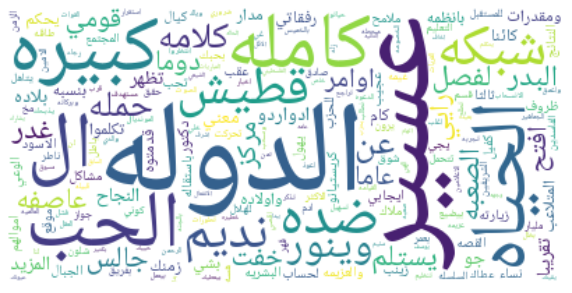

WordCloud of top 2000 words in personal dataset


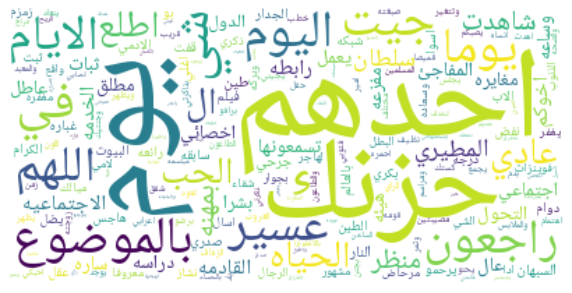

WordCloud of top 2000 words in sports dataset


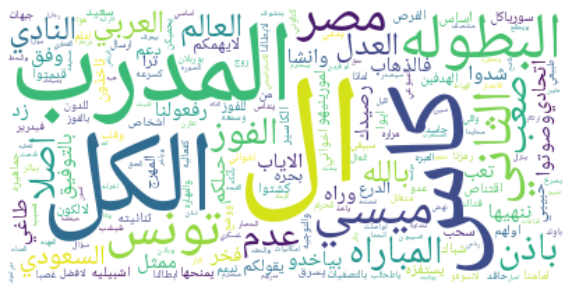

WordCloud of top 2000 words in politics dataset


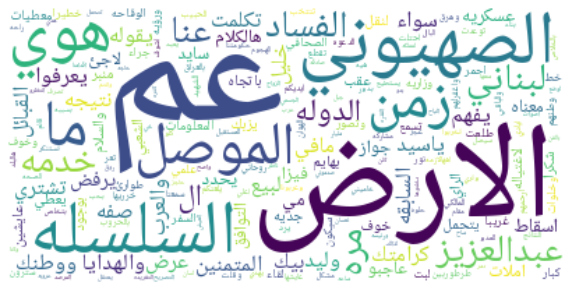

WordCloud of top 2000 words in religions dataset


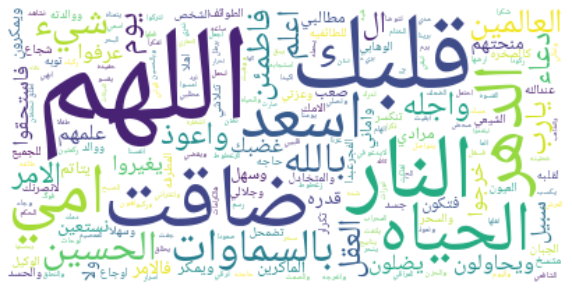

In [103]:
# Wordcoulds
for k, v in datasetDict.items():
        clean_text_list = v['clean_text'].values # extract text column as list
        words_list = [text.split() for text in clean_text_list] # split each tweet into the corresponding words
        all_words = [word for text_words in words_list for word in text_words] # merge words into one list
        words_count = collections.Counter(all_words) # count the occurences/frequency of each word
        # get top n words (most common)
        top_n = 2000
        top_n_words_df = pd.DataFrame(words_count.most_common(top_n),columns=['word', 'count'])
        # Make text readable for a non-Arabic library like wordcloud
        text = arabic_reshaper.reshape(" ".join(top_n_words_df['word']))
        text = get_display(text)
        # Generate a word cloud image
        plt.figure(figsize=(10,10))
        wordcloud = WordCloud(font_path='NotoNaskhArabic-Regular.ttf', background_color='white').generate(text)
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
        print('WordCloud of top ' + str(top_n) + ' words in '+ k + ' dataset')
        plt.show()
        # Export to an image
        #wordcloud.to_file("arabic_example.png")

In [104]:
!pip install tashaphyne

     |████████████████████████████████| 244 kB 5.1 MB/s 


In [105]:
from textblob import TextBlob
from tashaphyne.stemming import ArabicLightStemmer
from nltk.stem.isri import ISRIStemmer

In [106]:
#Stemming
ArListem = ArabicLightStemmer()

def stem(text):
    zen = TextBlob(text)
    words = zen.split()
    Stemmed = list()
    for w in words:
        ArListem.light_stem(w)
        Stemmed.append(ArListem.get_stem())
    return " ".join(Stemmed)

In [107]:
for k, v in datasetDict.items():
  v['stemmed_text'] = v['clean_text'].apply(stem)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
for t in spo_df['stemmed_text']:
  print(t)

ذاكره عتقد كريستيانو فضل اعب عالم اكا ميس ثالث حدث عكس
زعج مستو خارج رض مثيل ون وز
لف لف مبر منتخب سور سب حترام جميع عب روح عزيمه شكر شي قدمت مدار تصف نهايه رغم ظروف استرالي سوري
منرجع منتخب اصدقائ ثانو لي نت رهم رماد شبيح طلع يكرهوا منتخب شمتان هال عامل جمعور من جي
له اثن غال انو قريب ول ناد حب روح سعود جب شير هلال
ياب جرح هلال نيشيمور حرم هلال ادوارد
اس عالم يوحش قوه قوه ار له ضعف جمهور خط نار ورط تم ي…
اسنسي خراف كلش يوم قتال دون ثير يحاول قدم
صف مزيج ظاهره زيد احتفل هدف ستلم كره غباء لعب دور
قام عصر يوم ملعب ناد ضم مبارا مهم نسبه ناد ادار جمهور كريم فوز اش ا…
منتخب رنس حالي منتخب جبار خا حصل جم توقع سو شي مونديال قادم
منتخب بنا سجل هدف اول دقيقه واحده عشر منتخب وريا شماليه بطول اس سي ملعب يروت بلد
منتخب اقل عتبر موت ستحق اكثريه نت ؤيد فريق سن سور شكر استرالي
خسر مهم نك رفعتو راس قدام عالم لو كل عرف مي منتخب سور مي سور قاسي سور قاسي شكر كن هالفرح
حز عصر جا رسال رسال مؤلم له عي شي خص هلال اق حوال صاب اد…
هدف را وم شوف خت شوف
خليو يستاهل ماه شايل فريق هالموسم ظهر برع جمهور ١٠٠ ذكر حسا

In [109]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer_count1 = CountVectorizer()
vectorizer_count2 = CountVectorizer(ngram_range=(1,2))
vectorizer_Tfidf1 = TfidfVectorizer()
vectorizer_Tfidf2 = TfidfVectorizer(ngram_range=(1,2))

Vectorizers = {"count1": vectorizer_count1, "count2": vectorizer_count2, "Tfidf1": vectorizer_Tfidf1, "Tfidf2": vectorizer_Tfidf2}

In [110]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

clf_Lsvc = LinearSVC()
clf_svc = SVC()

Classifiers = {"LinearSvc": clf_Lsvc, "Svc": clf_svc}

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

for k, v in datasetDict.items():
  X = v['clean_text']
  encoder = LabelEncoder()
  y = encoder.fit_transform(v['polarity'])
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
  print("--------------------------------------------------------------------------- Dataset:",k )
  print('Training: ', x_train.shape)
  print('Testing: ', x_test.shape)

  for k1, v1 in Vectorizers.items():
    X_train = v1.fit_transform(x_train)
    features_count = len(v1.vocabulary_)
    print("-------------------------------------- Vecotizor: ", k1)
    print('Number of features: ', features_count)
    print('Shape of training X: ', X_train.shape)
    X_test = v1.transform(x_test)
    print('Shape of testing X: ', X_test.shape)

    for k2, v2 in Classifiers.items():
      v2.fit(X_train, y_train)
      # check the training and testing accuracies
      print("------------------- Classifier: ", k2)
      print('Training Accuracy: ', v2.score(X_train,y_train))
      print('Testing Accuracy: ', v2.score(X_test,y_test))
      predections = v2.predict(X_test)
      print('Testing F1 score: ', f1_score(y_test, predections))
      print('Testing precision score: ', precision_score(y_test, predections))
      print('Testing recall score: ', recall_score(y_test, predections))
    
    if k1 == "count1":
      MAX_WORDS = int(len(v1.vocabulary_) * 0.5)
      vectorizer_countMax = CountVectorizer(max_features=MAX_WORDS)
      X_train = vectorizer_countMax.fit_transform(x_train)
      print("-------------------------------------- Vecotizor: ", k1, " Max ", MAX_WORDS, " features." )
      print('Number of features: ', features_count * 0.5)
      print('Shape of training X: ', X_train.shape)
      X_test = vectorizer_countMax.transform(x_test)
      print('Shape of testing X: ', X_test.shape)
      for kk, vv in Classifiers.items():
        vv.fit(X_train, y_train)
        # check the training and testing accuracies
        print("------------------- Classifier: ", kk)
        print('Training Accuracy: ', vv.score(X_train,y_train))
        print('Testing Accuracy: ', vv.score(X_test,y_test))
        predections = vv.predict(X_test)
        print('Testing F1 score: ', f1_score(y_test, predections))
        print('Testing precision score: ', precision_score(y_test, predections))
        print('Testing recall score: ', recall_score(y_test, predections))

--------------------------------------------------------------------------- Dataset: All
Training:  (2492,)
Testing:  (623,)
-------------------------------------- Vecotizor:  count1
Number of features:  14724
Shape of training X:  (2492, 14724)
Shape of testing X:  (623, 14724)
------------------- Classifier:  LinearSvc
Training Accuracy:  0.9867576243980738
Testing Accuracy:  0.8202247191011236
Testing F1 score:  0.7575757575757577
Testing precision score:  0.8101851851851852
Testing recall score:  0.7113821138211383
------------------- Classifier:  Svc
Training Accuracy:  0.9839486356340289
Testing Accuracy:  0.8025682182985554
Testing F1 score:  0.7159353348729793
Testing precision score:  0.8288770053475936
Testing recall score:  0.6300813008130082
-------------------------------------- Vecotizor:  count1  Max  7362  features.
Number of features:  7362.0
Shape of training X:  (2492, 7362)
Shape of testing X:  (623, 7362)
------------------- Classifier:  LinearSvc
Training Accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  LinearSvc
Training Accuracy:  0.9867576243980738
Testing Accuracy:  0.8170144462279294
Testing F1 score:  0.7532467532467532
Testing precision score:  0.8055555555555556
Testing recall score:  0.7073170731707317
------------------- Classifier:  Svc
Training Accuracy:  0.9867576243980738
Testing Accuracy:  0.8073836276083467
Testing F1 score:  0.7379912663755458
Testing precision score:  0.7971698113207547
Testing recall score:  0.6869918699186992
-------------------------------------- Vecotizor:  Tfidf1
Number of features:  14724
Shape of training X:  (2492, 14724)
Shape of testing X:  (623, 14724)
------------------- Classifier:  LinearSvc
Training Accuracy:  0.9867576243980738
Testing Accuracy:  0.8218298555377207
Testing F1 score:  0.7560439560439561
Testing precision score:  0.8229665071770335
Testing recall score:  0.6991869918699187
------------------- Classifier:  Svc
Training Accuracy:  0.9863563402889246
Testing Accuracy:  0.797752808988764
Tes

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  Svc
Training Accuracy:  0.9787664307381193
Testing Accuracy:  0.8669354838709677
Testing F1 score:  0.5074626865671642
Testing precision score:  0.8947368421052632
Testing recall score:  0.3541666666666667
-------------------------------------- Vecotizor:  Tfidf1
Number of features:  6553
Shape of training X:  (989, 6553)
Shape of testing X:  (248, 6553)
------------------- Classifier:  LinearSvc
Training Accuracy:  0.9888776541961577
Testing Accuracy:  0.8870967741935484
Testing F1 score:  0.611111111111111
Testing precision score:  0.9166666666666666
Testing recall score:  0.4583333333333333
------------------- Classifier:  Svc
Training Accuracy:  0.9868554095045501
Testing Accuracy:  0.8709677419354839
Testing F1 score:  0.5294117647058825
Testing precision score:  0.9
Testing recall score:  0.375
-------------------------------------- Vecotizor:  Tfidf2
Number of features:  16758
Shape of training X:  (989, 16758)
Shape of testing X:  (248, 16758)
-

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

for k, v in datasetDict.items():
  X = v['stemmed_text']
  encoder = LabelEncoder()
  y = encoder.fit_transform(v['polarity'])
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
  print("--------------------------------------------------------------------------- Dataset:",k )
  print('Training: ', x_train.shape)
  print('Testing: ', x_test.shape)

  for k1, v1 in Vectorizers.items():
    X_train = v1.fit_transform(x_train)
    features_count = len(v1.vocabulary_)
    print("-------------------------------------- Vecotizor: ", k1)
    print('Number of features: ', features_count)
    print('Shape of training X: ', X_train.shape)
    X_test = v1.transform(x_test)
    print('Shape of testing X: ', X_test.shape)

    for k2, v2 in Classifiers.items():
      v2.fit(X_train, y_train)
      # check the training and testing accuracies
      print("------------------- Classifier: ", k2)
      print('Training Accuracy: ', v2.score(X_train,y_train))
      print('Testing Accuracy: ', v2.score(X_test,y_test))
      predections = v2.predict(X_test)
      print('Testing F1 score: ', f1_score(y_test, predections))
      print('Testing precision score: ', precision_score(y_test, predections))
      print('Testing recall score: ', recall_score(y_test, predections))
    
    if k1 == "count1":
      MAX_WORDS = int(len(v1.vocabulary_) * 0.5)
      vectorizer_countMax = CountVectorizer(max_features=MAX_WORDS)
      X_train = vectorizer_countMax.fit_transform(x_train)
      print("-------------------------------------- Vecotizor: ", k1, " Max ", MAX_WORDS, " features." )
      print('Number of features: ', features_count * 0.5)
      print('Shape of training X: ', X_train.shape)
      X_test = vectorizer_countMax.transform(x_test)
      print('Shape of testing X: ', X_test.shape)
      for kk, vv in Classifiers.items():
        vv.fit(X_train, y_train)
        # check the training and testing accuracies
        print("------------------- Classifier: ", kk)
        print('Training Accuracy: ', vv.score(X_train,y_train))
        print('Testing Accuracy: ', vv.score(X_test,y_test))
        predections = vv.predict(X_test)
        print('Testing F1 score: ', f1_score(y_test, predections))
        print('Testing precision score: ', precision_score(y_test, predections))
        print('Testing recall score: ', recall_score(y_test, predections))

--------------------------------------------------------------------------- Dataset: All
Training:  (2492,)
Testing:  (623,)
-------------------------------------- Vecotizor:  count1
Number of features:  7498
Shape of training X:  (2492, 7498)
Shape of testing X:  (623, 7498)
------------------- Classifier:  LinearSvc
Training Accuracy:  0.9867576243980738
Testing Accuracy:  0.8282504012841091
Testing F1 score:  0.7718550106609808
Testing precision score:  0.8116591928251121
Testing recall score:  0.7357723577235772
------------------- Classifier:  Svc
Training Accuracy:  0.9779293739967897
Testing Accuracy:  0.8105939004815409
Testing F1 score:  0.7203791469194314
Testing precision score:  0.8636363636363636
Testing recall score:  0.6178861788617886
-------------------------------------- Vecotizor:  count1  Max  3749  features.
Number of features:  3749.0
Shape of training X:  (2492, 3749)
Shape of testing X:  (623, 3749)
------------------- Classifier:  LinearSvc
Training Accuracy:  

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  LinearSvc
Training Accuracy:  0.9867576243980738
Testing Accuracy:  0.8378812199036918
Testing F1 score:  0.7789934354485777
Testing precision score:  0.8436018957345972
Testing recall score:  0.7235772357723578
------------------- Classifier:  Svc
Training Accuracy:  0.9847512038523274
Testing Accuracy:  0.8186195826645265
Testing F1 score:  0.744920993227991
Testing precision score:  0.8375634517766497
Testing recall score:  0.6707317073170732
-------------------------------------- Vecotizor:  Tfidf1
Number of features:  7498
Shape of training X:  (2492, 7498)
Shape of testing X:  (623, 7498)
------------------- Classifier:  LinearSvc
Training Accuracy:  0.985553772070626
Testing Accuracy:  0.8218298555377207
Testing F1 score:  0.753880266075388
Testing precision score:  0.8292682926829268
Testing recall score:  0.6910569105691057
------------------- Classifier:  Svc
Training Accuracy:  0.9843499197431782
Testing Accuracy:  0.812199036918138
Testing F

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


------------------- Classifier:  Svc
Training Accuracy:  0.9787664307381193
Testing Accuracy:  0.8629032258064516
Testing F1 score:  0.48484848484848486
Testing precision score:  0.8888888888888888
Testing recall score:  0.3333333333333333
-------------------------------------- Vecotizor:  Tfidf1
Number of features:  3925
Shape of training X:  (989, 3925)
Shape of testing X:  (248, 3925)
------------------- Classifier:  LinearSvc
Training Accuracy:  0.9888776541961577
Testing Accuracy:  0.9112903225806451
Testing F1 score:  0.7179487179487181
Testing precision score:  0.9333333333333333
Testing recall score:  0.5833333333333334
------------------- Classifier:  Svc
Training Accuracy:  0.9858442871587462
Testing Accuracy:  0.875
Testing F1 score:  0.537313432835821
Testing precision score:  0.9473684210526315
Testing recall score:  0.375
-------------------------------------- Vecotizor:  Tfidf2
Number of features:  13912
Shape of training X:  (989, 13912)
Shape of testing X:  (248, 13912

In [114]:
  # Create a plot of the PCA results
from itertools import cycle
def plot_PCA_2D(data, target, target_names):
    colors = cycle(['g','r'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

Dataset:  (3115,)
-------------------------------------- Vecotizor: Tfidf
Number of features:  19921
Shape of training X:  (3115, 19921)


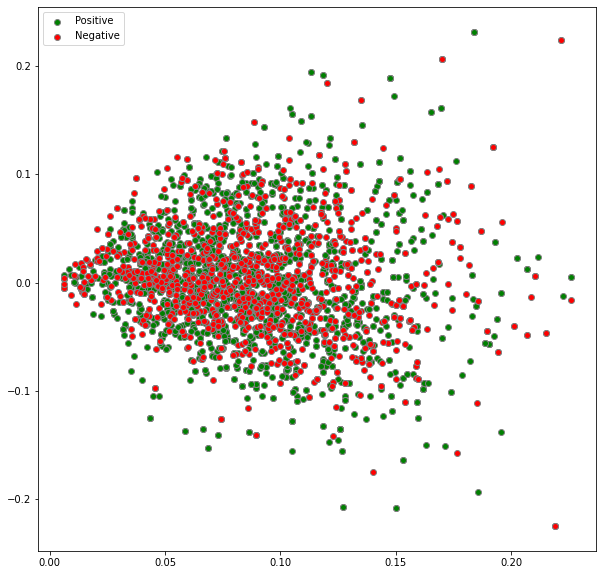

In [121]:
  from sklearn.decomposition import PCA, TruncatedSVD

# Take all of the data and plot it on 2 dimensions
#pca = PCA(n_components=2) 
  svd = TruncatedSVD(n_components=2)


  X= cor_df['text']
  encoder = LabelEncoder()
  y = encoder.fit_transform(cor_df['polarity'])
  print('Dataset: ', X.shape)

  vectorizer = TfidfVectorizer()
  X_vectorized = vectorizer.fit_transform(X)
  features_count = len(vectorizer.vocabulary_)
  print("-------------------------------------- Vecotizor: Tfidf")
  print('Number of features: ', features_count)
  print('Shape of training X: ', X_vectorized.shape)
  
  #pca.fit(X_vectorized)
  #pca_features = pca.transform(X_vectorized)
  svd.fit(X_vectorized)
  svd_features = svd.transform(X_vectorized)
  # plot of all the numbers
  plot_PCA_2D(svd_features, target=y, target_names= (['Positive','Negative']))